In [1]:
import os
from decimal import *
from copy import copy

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.stats import norm
from scipy.stats import multivariate_normal
import torch
import gpytorch

from models.preferential_gp import *

%matplotlib inline

In [2]:
from math import floor, log10


# Define function for string formatting of scientific notation
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    explicitly.
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    """
    if exponent is None:
        exponent = int(floor(log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)

[0.13533553 0.16447473 0.19789854 0.23574615 0.2780366  0.3246531
 0.37531054 0.42955685 0.4867526  0.5460747  0.6065295  0.66697764
 0.72614926 0.7827039  0.8352699  0.88249606 0.92311645 0.9559974
 0.9801982  0.9950114  1.         0.99501234 0.9801982  0.9559965
 0.92311645 0.8824969  0.8352699  0.7827039  0.72614855 0.666977
 0.60653067 0.54607415 0.48675188 0.42955765 0.3753113  0.32465246
 0.27803725 0.23574637 0.19789863 0.16447449]
tensor([0.3750])


/home/htlee/work_drive/pref_bo/preferential_bo/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/htlee/work_drive/pref_bo/preferential_bo/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/htlee/work_drive/pref_bo/preferential_bo/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


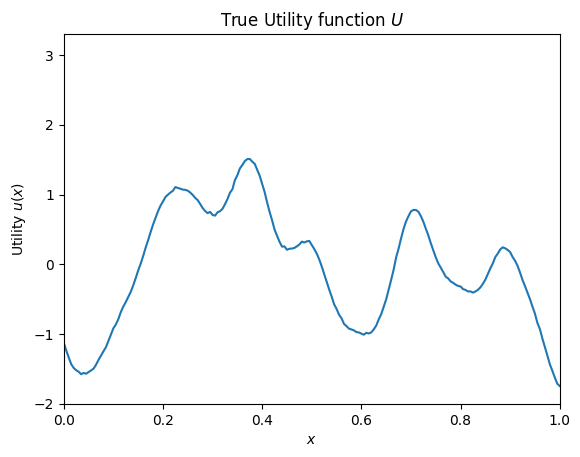

In [3]:
torch.manual_seed(0)
np.random.seed(0)

lengthscale = 0.05
kernel = gpytorch.kernels.RBFKernel()
kernel.lengthscale = torch.tensor(lengthscale)

candidate_size = 201
# X = torch.linspace(0, 1, candidate_size)

# class GPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(GPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ZeroMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
#         # Initialize hyperparameters to match your GPy code
#         self.covar_module.base_kernel.lengthscale = 0.05
#         self.covar_module.outputscale = 1.0 # variance

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = GPModel(None, None, likelihood)

# model.eval()
# with torch.no_grad():
#     # Get the multivariate normal distribution at X
#     prior_dist = model(X)
    
#     # Draw a single sample (equivalent to your Cholesky dot product)
#     # rsalt is used for reproducibility
#     true_f = prior_dist.sample()

X = torch.linspace(0, 1, candidate_size).unsqueeze(1)
prior_mean = torch.zeros(candidate_size)
prior_cov = kernel(X, X)
print(prior_cov.numpy()[50, 30:70])
prior_chol = torch.linalg.cholesky(prior_cov + 1e-8 * torch.eye(candidate_size))
true_f = prior_mean.unsqueeze(1) + prior_chol @ (torch.randn(candidate_size).unsqueeze(1))


x_max_idx = torch.argmax(true_f)
print(X[x_max_idx])

plt.plot(X.detach().squeeze().numpy(), true_f.detach().numpy())
plt.axis([0, 1, -2, 3.3])
plt.xlabel(r"$x$")
plt.ylabel(r"Utility $u(x)$")
plt.title(r"True Utility function $U$")
# plt.xticks([], [])
# plt.yticks([], [])
plt.xlim(0, 1)
plt.ylim(-2, 3.3)
# plt.savefig('../latent_func.pdf')
plt.show()
plt.close()

In [4]:
# Problem dimension
candidate_size = 201
num_duels = 50
seed = 0
input_dim = 1

# Seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# Define observation noise and domain bound [0, 1]^d
noise_std = 1e-2
x_bound = [torch.zeros(input_dim), torch.ones(input_dim)]

# Sample (2 * num_duels) integer points from [0..candidate_size]
idx = torch.tensor(np.random.choice(candidate_size, 2 * num_duels))
idx = idx.ravel().tolist()

X_init = X[idx].reshape(num_duels, 2 * input_dim)

y_init = true_f[idx]
y_init = y_init.reshape(num_duels, 2)

sort_idx = torch.argsort(y_init, dim=1) # Win elem: 1, lose elem: 0

# For dim=1 indicies for larger f values comes first
X_init_sort = torch.take_along_dim(X_init, sort_idx, dim=1).flip(dims=[1]) # ::-1 reverse copy
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
kernel.base_kernel.lengthscale = torch.tensor(lengthscale)
kernel.outputscale = torch.tensor(1.0)
print(kernel)

idx = torch.tensor(idx).reshape(num_duels, 2 * input_dim)
idx = torch.take_along_dim(idx, sort_idx, dim=1).flip(dims=[1])
print(idx)


ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)
tensor([[ 47, 172],
        [192, 117],
        [ 67, 195],
        [103,   9],
        [ 36,  21],
        [ 70,  87],
        [140,  88],
        [ 58, 193],
        [ 39,  87],
        [ 88, 174],
        [ 81, 165],
        [ 77,  25],
        [ 72,   9],
        [148, 115],
        [ 79, 197],
        [175, 192],
        [ 82,  99],
        [177,  29],
        [147, 147],
        [142, 167],
        [ 32, 193],
        [185,   9],
        [ 32, 127],
        [151,  31],
        [163, 114],
        [183,  28],
        [ 34, 128],
        [164, 128],
        [ 53, 133],
        [ 38,  17],
        [ 79, 132],
        [ 42, 105],
        [ 31, 186],
        [120,   1],
        [ 65, 169],
        [ 57,  35],
        [102, 119],
        [174,  11],
        [ 82,  91],
        [142, 128],
        [ 53,  99],
        [140, 121],
        [ 84, 170],
     

In [ ]:
i = 3
focus_x_idx = [idx[i, 0], idx[i, 1]]

pref_gp_la = PrefGPLaplace(
    X_init_sort.numpy(), kernel, kernel_bounds=x_bound, noise_std=noise_std
)
pref_gp_la.inference()

mean_la, var_la = pref_gp_la.predict(X)
mean_la = mean_la.ravel()

mean_la_pdf, cov_la_pdf = pref_gp_la.predict(X[focus_x_idx], full_cov=True)
false_prob_la = norm.cdf(
    0,
    loc=mean_LP_pdf[0] - mean_LP_pdf[1],
    scale=np.sqrt(cov_LP_pdf[1, 1] + cov_LP_pdf[0, 0] - 2 * cov_LP_pdf[0, 1]),
)


RuntimeError: Error in Laplace approximation may be large

In [ ]:
fig = plt.figure(figsize=(14, 5))
gs = GridSpec(1, 14)
ax4 = plt.subplot(gs[0, :9])
ax5 = plt.subplot(gs[0, 9:])
# ax6 = plt.subplot(gs[0, 3])

# PGP_LP.sample(sample_size=8)
# sample_path_LP = PGP_LP.evaluate_sample(X)

# for i in range(8):
#     ax4.plot(np.ravel(X), sample_path_LP[:,i], linestyle="dotted")

ax4.plot(
    np.ravel(X),
    true_f,
    color="black",
    linestyle="dashed",
    label="black-box utility function",
)
ax4.plot(X.ravel(), mean_LP, label="prediction")
ax4.fill_between(
    X.ravel(),
    mean_LP - 1.96 * std_LP,
    mean_LP + 1.96 * std_LP,
    color="lightblue",
    label="uncertainty",
)
for i in range(len(focus_x_idx)):
    ax4.vlines(X[focus_x_idx[i]], -3, 3.5, linestyle="solid", color="red")
ax4.set_xticks([X[focus_x_idx[0]][0], X[focus_x_idx[1]][0]])
ax4.set_xticklabels([r"$x_w$", r"$x_l$"])
ax4.set_yticks([])
# ax4.set_xticklabels([r"$x^{(1)}_{t+1}$"])
ax4.set_xlim(0, 1)
ax4.set_ylim(-3.0, 3.5)
ax4.set_title("Laplace approximation")
# ax4.legend(loc="upper left")

# ax4.plot(X.ravel(), mean_acc, label="predictive mean", color="red")
# ax4.fill_between(X.ravel(), lower_acc, upper_acc, color="pink", alpha=0.5, label=r"95 \% credible interval")

pdf = multivariate_normal.pdf(F_fir, mean=mean_LP_pdf.ravel(), cov=cov_LP_pdf)
heatmap_exact = ax5.contour(
    F1_fir, F2_fir, pdf.reshape(np.size(plot_f_fir), np.size(plot_f_fir)), levels=levels
)
ax5.plot(
    plot_f_fir,
    plot_f_fir,
    linestyle="dashed",
    color="lightgreen",
    label=r"$f(x_w) \! = \! f(x_l)$",
)
# ax5.legend(loc="lower right")
ax5.set_xticks([])
ax5.set_yticks([])

ax5.set_ylabel(r"$f(x_l)$")
ax5.set_xlabel(r"$f(x_w)$")
# ax5.set_title(r"$\Pr \left( f(x_w) \! \leq \! f(x_l) \right)\! = $ " + sci_notation(false_prob_exact_acc, 1, 1))
ax5.set_title(r"${\rm PDF}(f(x_w), f(x_l))$")
ax5.text(
    np.min(plot_f_fir) + 0.1,
    np.max(plot_f_fir) - y_adjst,
    r"$\Pr \left( f(x_w) \! \leq \! f(x_l) \right)\!$ "
    + "\n"
    + "$= {:.3f}$ ".format(false_prob_LP[0]),
)

plt.tight_layout()
plt.savefig("Illustrative_example/preferentialGP_LP.pdf")
plt.show()
plt.close()